In [1]:
from simulation.simulator import Simulator

In [2]:
def diffeq_lorenz_system(t, z, args):
    """
    Coupled differential equations representing the Lorenz system.
    """
    sigma, rho, beta = args
    x1, x2, x3 = z
    dx1dt = sigma * (x2 - x1)
    dx2dt = x1 * (rho - x3) - x2
    dx3dt = x1 * x2 - beta * x3
    return [dx1dt, dx2dt, dx3dt]

In [3]:
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

ics = []
for i in range(0, 10000):
    x1_0 = 5.0 + 0.0001 * i
    x2_0 = 1.0
    x3_0 = 1.0
    ics.append([x1_0, x2_0, x3_0])

In [4]:
scipy_sim = Simulator("scipy")

In [5]:
# scipy_sim.cpu_sequential_solve_ics(
#     ics, diffeq_lorenz_system, [sigma, rho, beta], 0.0, 100.0, 0.01
# )

In [6]:
scipy_sim.cpu_parallel_solve_ics(
    ics=ics,
    num_processes=10,
    diffeq_func=diffeq_lorenz_system,
    args=[sigma, rho, beta],
    ti=0.0,
    tf=100.0,
    dt=0.01,
)

Benchmarked time = 0.862696647644043
Function benchmarked was: <function Simulator.cpu_parallel_solve_ics at 0x7fa4dd16b1c0>


cpu_serial_solve_ics(ics, scipy_sim, diffeq_lorenz_system, [])

In [7]:
# parallel operations not garunteed to return solutions in order, so we sort them afterwards for visualization
sorted_sols = sorted(scipy_sim.sols, key=lambda x: x[1]["ic"])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean


def compute_distances(first_solution, all_solutions):
    time_steps = len(first_solution[0]["t"])
    num_solutions = len(all_solutions)

    y_distances = np.zeros((num_solutions, time_steps))
    ic_distances = np.zeros(num_solutions)

    for i, sol in enumerate(all_solutions):
        ic_distances[i] = euclidean(first_solution[1]["ic"], sol[1]["ic"])
        for t in range(time_steps):
            y_distances[i, t] = euclidean(
                (
                    first_solution[0]["y"][0][t],
                    first_solution[0]["y"][1][t],
                    first_solution[0]["y"][2][t],
                ),
                (sol[0]["y"][0][t], sol[0]["y"][1][t], sol[0]["y"][2][t]),
            )

    return y_distances, ic_distances


first_solution = sorted_sols[0]

y_distances, ic_distances = compute_distances(first_solution, sorted_sols)

In [9]:
y_distances.shape, ic_distances.shape

((100, 10000), (100,))

In [10]:
average_y_distances = np.average(y_distances[1:], axis=1)

In [11]:
max_y_distances = np.max(y_distances[1:], axis=1)

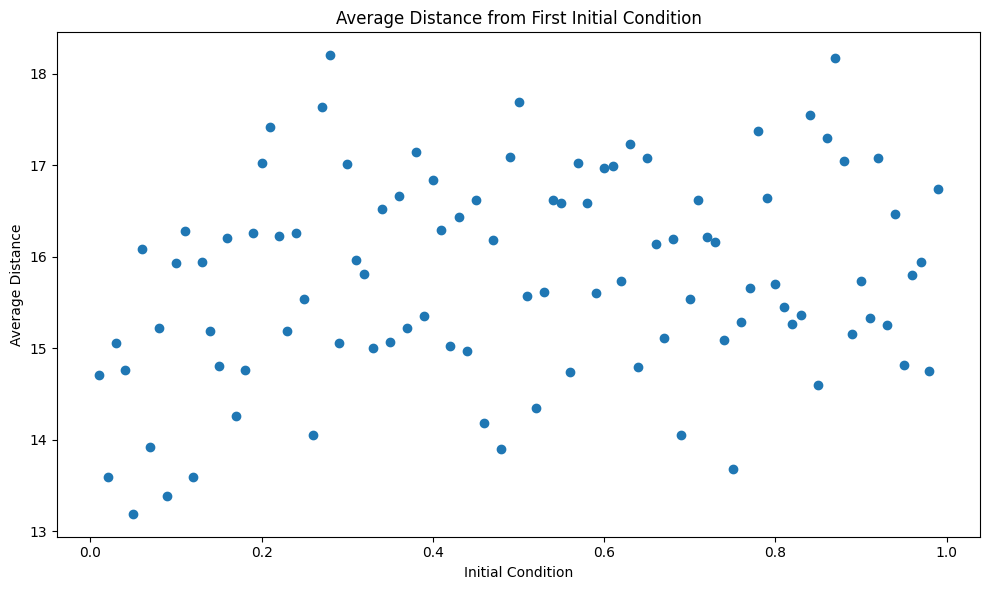

In [14]:
import numpy as np
import matplotlib.pyplot as plt

initial_conditions = np.arange(1, len(scipy_sim.sols))

plt.figure(figsize=(10, 6))
plt.scatter(ic_distances[1:], average_y_distances)

plt.title("Average Distance from First Initial Condition")
plt.xlabel("Initial Condition")
plt.ylabel("Average Distance")
plt.tight_layout()
plt.show()